# Imputación de Imágenes usando Modelos de Difusión

Este notebook demuestra cómo realizar la imputación de imágenes utilizando un modelo de puntuación (score model) pre-entrenado basado en Ecuaciones Diferenciales Estocásticas (SDEs), siguiendo las metodologías propuestas por Yang Song et al.

**Objetivo:** Rellenar partes faltantes (enmascaradas) de una imagen (CIFAR-10) utilizando información contextual aprendida por el modelo de difusión. La máscara se generará a partir de imágenes del dataset MNIST.

**Pasos:**
1.  **Configuración:** Importar librerías, configurar el entorno y definir parámetros.
2.  **Cargar Modelo:** Cargar el modelo de puntuación pre-entrenado y la configuración SDE correspondiente.
3.  **Cargar Datos:** Cargar los datasets CIFAR-10 (imágenes originales) y MNIST (para generar máscaras).
4.  **Preparar Entradas:** Crear las máscaras y preparar los tensores de entrada para la imputación.
5.  **Visualizar Entrada:** Mostrar las imágenes originales con la máscara aplicada (zonas a imputar en negro).
6.  **Ejecutar Imputación:** Utilizar el `imputation_sampler` para generar el contenido faltante.
7.  **Visualizar Resultados:** Mostrar las imágenes imputadas y compararlas con las originales.


## 1. Configuración e Importaciones

Cargamos las librerías necesarias, configuramos el autoreload, suprimimos warnings y añadimos las rutas de nuestros módulos locales al path de Python.

In [3]:
# Configuración inicial y carga de extensiones
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import json
import sys
import os
from functools import partial
import matplotlib.pyplot as plt

# Añadir directorios locales al path para importar módulos propios
module_paths = ["diffusion", "utils", "models", "samplers", "imputation"]
for path_name in module_paths:
    module_path = os.path.abspath(path_name)
    if module_path not in sys.path:
        sys.path.insert(0, module_path)
        print(f"Añadido al path: {module_path}")

# Importaciones de PyTorch y Torchvision
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
import torchvision.transforms as transforms

# Importaciones específicas del proyecto (modelos, SDE, utilidades)
from diffusion.schedules import LinearSchedule, CosineSchedule
from diffusion.sde import VESDE, VPSDE, SubVPSDE
from imputation.imputed_utilities import imputation_sampler, create_mask_from_mnist, show_images
from models import score_net
import tqdm # Para barras de progreso 


# Modelo
from score_net import ScoreNet


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1.1. Configuración del Dispositivo (CPU/GPU)

Detectamos si hay una GPU disponible y configuramos PyTorch para usarla. De lo contrario, usará la CPU.

In [4]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print("GPU disponible. Usando CUDA.")
    # torch.backends.cudnn.benchmark = True # Puede acelerar si los tamaños de entrada no varían
else:
    DEVICE = torch.device('cpu')
    print("GPU no encontrada. Usando CPU.")

n_threads = torch.get_num_threads()
print(f'Número de hilos de PyTorch: {n_threads}')

GPU no encontrada. Usando CPU.
Número de hilos de PyTorch: 10


## 2. Carga del Modelo Pre-entrenado y Configuración SDE

Cargamos el modelo de puntuación (`ScoreNet`) entrenado previamente y definimos la configuración de la SDE con la que fue entrenado.

In [5]:
# --- Parámetros de Configuración del Modelo y SDE ---
# Estos deben coincidir con los del checkpoint que se va a cargar

# Parámetros de la Imagen (ajustados a CIFAR-10)
IMG_SIZE = 32
IMG_CHANNELS = 3

# Parámetros de la SDE 
# Elige uno: 'VE', 'VP_Linear', 'VP_Cosine', 'SubVP_Linear', 'SubVP_Cosine'
MODEL_TYPE = 'VE'  # <--- CAMBIA ESTO PARA SELECCIONAR EL MODELO

SIGMA_MIN = 0.01         # Parámetro sigma_min para VE SDE
SIGMA_MAX = 50.0         # Parámetro sigma_max para VE SDE
SIGMA = 50.0             # Parámetro sigma para VE SDE (¿redundante si se usan min/max?) -> Verificar definición de VESDE
T_END = 1.0              # Tiempo final (relevante para VP/SubVP)
BETA_MIN = 0.1           # Para VP/SubVP SDE
BETA_MAX = 20.0          # Para VP/SubVP SDE
SCHEDULE_S = 0.008                # Para CosineSchedule

In [6]:
# --- Instanciar SDE según la configuración ---
try:
    if MODEL_TYPE == 'VE':
        sde_instance = VESDE(sigma_min=SIGMA_MIN, sigma_max=SIGMA_MAX, sigma=SIGMA)
        print(f"Inicializado VESDE (sigma_min={SIGMA_MIN}, sigma_max={SIGMA_MAX}, sigma={SIGMA})")
    elif MODEL_TYPE == 'VP_Linear':
        schedule = LinearSchedule(beta_min=BETA_MIN, beta_max=BETA_MAX, T=T_END)
        sde_instance = VPSDE(schedule=schedule)
        print(f"Inicializado VPSDE con Schedule Lineal (beta_min={BETA_MIN}, beta_max={BETA_MAX})")
    elif MODEL_TYPE == 'VP_Cosine':
        schedule = CosineSchedule(T=T_END, s=SCHEDULE_S)
        sde_instance = VPSDE(schedule=schedule)
        print(f"Inicializado VPSDE con Schedule Coseno (s={SCHEDULE_S})")
    elif MODEL_TYPE == 'SubVP_Linear':
        schedule = LinearSchedule(beta_min=BETA_MIN, beta_max=BETA_MAX, T=T_END)
        sde_instance = SubVPSDE(schedule=schedule)
        print(f"Inicializado SubVPSDE con Schedule Lineal (beta_min={BETA_MIN}, beta_max={BETA_MAX})")
    elif MODEL_TYPE == 'SubVP_Cosine':
        schedule = CosineSchedule(T=T_END, s=SCHEDULE_S)
        sde_instance = SubVPSDE(schedule=schedule)
        print(f"Inicializado SubVPSDE con Schedule Coseno (s={SCHEDULE_S})")
    else:
        raise ValueError(f"Tipo de modelo desconocido: {MODEL_TYPE}")


except Exception as e:
    print(f"Error durante la inicialización del modelo o SDE: {e}")
    raise

Inicializado VESDE (sigma_min=0.01, sigma_max=50.0, sigma=50.0)


In [7]:
# --- Definición y Carga del Modelo ScoreNet ---
print("Definiendo la arquitectura del modelo ScoreNet...")
score_model = score_net.ScoreNet(
    marginal_prob_std=partial(sde_instance.sigma_t), # Pasar la función correcta
    input_channels=IMG_CHANNELS,
    output_channels=IMG_CHANNELS,
    base_channels=128,
    channel_mults=(1, 2, 2, 2),
    num_res_blocks=2,
    attn_resolutions=(8,), # Resolución donde aplicar attention (para 32x32 -> 32/4 = 8)
    dropout=0.1
).to(DEVICE)

Definiendo la arquitectura del modelo ScoreNet...


In [8]:
# Cargamos el modelo desde un checkpoint si existe
checkpoints_files = {'VE': 200, 'VP_Linear': 50, 'VP_Cosine': 100, 'SubVP_Linear': 130, 'SubVP_Cosine': 20}

score_model_path = f'./checkpoints/scorenet_cifar10_{MODEL_TYPE}_epoch_{checkpoints_files[MODEL_TYPE]}.pth'
print(score_model_path)

if os.path.exists(score_model_path):
    score_model.load_state_dict(torch.load(score_model_path, map_location=DEVICE))

    print(f"ScoreNet cargado desde {score_model_path}")
else:
    print(f"WARN: No se encontró checkpoint de ScoreNet en {score_model_path}")


# score_model.load_state_dict(torch.load(f'./checkpoints/scorenet_cifar10_{MODEL_TYPE}_epoch_{checkpoints_files[MODEL_TYPE]}.pth', map_location=DEVICE))
score_model.eval()
print("Checkpoint loaded successfully.")

./checkpoints/scorenet_cifar10_VE_epoch_200.pth
ScoreNet cargado desde ./checkpoints/scorenet_cifar10_VE_epoch_200.pth
Checkpoint loaded successfully.


## 3. Carga y Preparación de Datos

Cargamos el dataset CIFAR-10, que contiene las imágenes en color que queremos imputar. También cargamos el dataset MNIST, que usaremos para generar máscaras binarias (los dígitos definirán las áreas a *ocultar* y posteriormente imputar en las imágenes CIFAR-10).

Se definen transformaciones específicas para cada dataset:
* **CIFAR-10:** Se convierten a Tensor y se normalizan a `[-1, 1]`, que es el rango esperado por el modelo pre-entrenado.
* **MNIST:** Se redimensionan al tamaño de las imágenes CIFAR-10 (32x32) y se convierten a Tensor `[0, 1]`. No se normalizan a `[-1, 1]` porque se usarán para crear una máscara binaria basada en un umbral sobre `[0, 1]`.

Creamos DataLoaders para ambos datasets para poder iterar sobre ellos en batches. 

In [9]:
# --- Constantes para la Carga de Datos ---
DATA_BATCH_SIZE = 64  # Tamaño del batch para la demostración de imputación
NUM_WORKERS = min(4, os.cpu_count() // 2 if os.cpu_count() > 1 else 1) # Número de workers para DataLoader

# --- Transformaciones ---
# Para CIFAR-10: Convertir a Tensor y normalizar a [-1, 1]
cifar_transform = transforms.Compose([
    transforms.ToTensor(), # Rango [0, 1]
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) # Rango [-1, 1]
])

# Para MNIST: Redimensionar a 32x32 y convertir a Tensor [0, 1]
mnist_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), # Asegurar mismo tamaño que CIFAR
    transforms.ToTensor() # Rango [0, 1]
])

# --- Datasets ---
print("Descargando/Cargando Datasets...")
try:
    cifar_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=cifar_transform)
    mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=mnist_transform)
    print("Datasets cargados.")
except Exception as e:
    print(f"Error al descargar/cargar los datasets: {e}")
    raise

# --- DataLoaders ---
# Usamos drop_last=True para asegurar que los batches de zip tengan el mismo tamaño
cifar_loader = DataLoader(
    cifar_dataset,
    batch_size=DATA_BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=torch.cuda.is_available(), # Usar pin_memory si hay GPU
    drop_last=True
)
mnist_loader = DataLoader(
    mnist_dataset,
    batch_size=DATA_BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=torch.cuda.is_available(),
    drop_last=True
)
print("DataLoaders creados.")

Descargando/Cargando Datasets...
Datasets cargados.
DataLoaders creados.


## 4. Creación de la Máscara y Preparación de Entradas para Imputación

Obtenemos un batch de imágenes CIFAR-10 y un batch de imágenes MNIST. Usamos las imágenes MNIST para crear máscaras binarias donde el dígito (valores bajos, cercanos a 0) representará la zona a ocultar (valor 0 en la máscara) y el fondo (valores altos, cercanos a 1) representará la zona a mantener (valor 1 en la máscara).

Preparamos las entradas clave para el `imputation_sampler`:
* `x_known_input`: La imagen CIFAR-10 original completa (normalizada a `[-1, 1]`).
* `batch_masks`: La máscara binaria (`0` donde imputar, `1` donde mantener), con dimensiones `(B, 1, H, W)`.

Además, creamos una versión de la imagen CIFAR-10 con las zonas enmascaradas puestas a negro (`-1.0`) únicamente con fines de visualización, para ver claramente qué partes de la imagen se van a imputar.

In [10]:
# --- Obtener un batch de datos ---
print("Obteniendo un batch de CIFAR-10 y MNIST...")
try:
    # Usamos zip para iterar sobre ambos DataLoaders simultáneamente
    cifar_batch, mnist_batch = next(iter(zip(cifar_loader, mnist_loader)))
except StopIteration:
    print("Error: Uno de los DataLoaders está vacío o ha terminado. Reiniciando iteradores para demostración.")
    # Reiniciar los iteradores si es necesario (para ejecución repetida en notebook)
    cifar_iter = iter(cifar_loader)
    mnist_iter = iter(mnist_loader)
    cifar_batch = next(cifar_iter)
    mnist_batch = next(mnist_iter)

# Desempaquetar imágenes (ignoramos las etiquetas)
cifar_images, _ = cifar_batch
mnist_images, _ = mnist_batch
print(f"Batch obtenido: CIFAR shape={cifar_images.shape}, MNIST shape={mnist_images.shape}")

# --- Crear Máscara Binaria desde MNIST ---
# mnist_images están en [0, 1]. Queremos máscara 0 para dígito, 1 para fondo.
# Ajusta el umbral según sea necesario. Un umbral bajo hace que más área sea dígito (máscara=0).
MASK_THRESHOLD = 0.1
batch_masks = create_mask_from_mnist(mnist_images, threshold=MASK_THRESHOLD) # Esta función debería devolver 0 para dígito, 1 para fondo
print(f"Máscaras creadas con umbral {MASK_THRESHOLD}. Shape: {batch_masks.shape}")

# --- Preparar Inputs para el Sampler ---
# Mover tensores al dispositivo correcto (GPU o CPU)
x_known_input = cifar_images.clone().to(DEVICE) # Imagen original CIFAR [-1, 1]
batch_masks = batch_masks.to(DEVICE)          # Máscara binaria [0, 1]

# --- Crear Imagen con Máscara Negra (Solo para Visualización) ---
# Creamos un tensor negro (-1.0 ya que CIFAR está normalizado a [-1, 1])
black_tensor = torch.full_like(x_known_input, -1.0)
# Donde la máscara es 0 (dígito), ponemos negro. Donde es 1 (fondo), mantenemos la imagen original.
# torch.where necesita que la condición (máscara) sea booleana.
# La máscara (B, 1, H, W) se expandirá automáticamente a (B, C, H, W).
images_for_before_visualization = torch.where(batch_masks.bool(), x_known_input, black_tensor)
print("Imagen con máscara negra creada para visualización.")

Obteniendo un batch de CIFAR-10 y MNIST...
Batch obtenido: CIFAR shape=torch.Size([64, 3, 32, 32]), MNIST shape=torch.Size([64, 1, 32, 32])
Máscaras creadas con umbral 0.1. Shape: torch.Size([64, 1, 32, 32])
Imagen con máscara negra creada para visualización.



## 5. Visualizar la Entrada Enmascarada
Mostramos algunas imágenes del batch CIFAR-10 con las áreas correspondientes a los dígitos MNIST ocultas (en negro). Esto representa la información que el modelo de imputación tendrá disponible.


--- Imágenes Originales con Máscara Aplicada (Entrada para Imputación Visualizada) ---


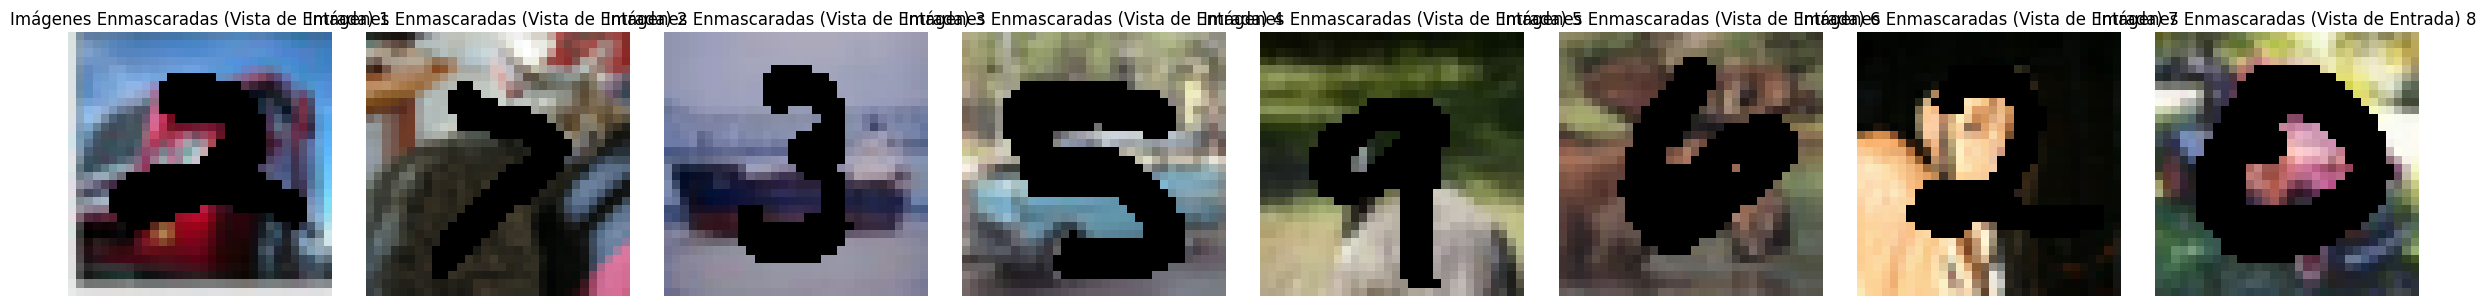

In [13]:
print("\n--- Imágenes Originales con Máscara Aplicada (Entrada para Imputación Visualizada) ---")
# Usamos la función show_images (asegúrate que esté importada y funcione con tensores [-1, 1])
# Ajusta num_to_show según cuántas quieras ver
show_images(images_for_before_visualization.cpu(), title="Imágenes Enmascaradas (Vista de Entrada)", num_to_show=8)
plt.show()

## 6. Ejecutar el Proceso de Imputación

Ahora llamamos a la función `imputation_sampler`. Esta función utiliza el modelo de puntuación (`score_model`), la SDE definida, la imagen original (`x_known`) y la máscara (`mask`) para, iterativamente, generar el contenido de las regiones enmascaradas (donde `mask == 0`).

**Parámetros Clave del Sampler:**
* `x_known`: La imagen original completa (tensor `(B, C, H, W)` en `[-1, 1]`).
* `mask`: La máscara binaria (tensor `(B, 1, H, W)` con `0` para imputar, `1` para mantener).
* `sde`: La instancia de la SDE (VE, VP, etc.).
* `score_model`: El modelo de puntuación pre-entrenado.
* `n_steps`: Número de pasos de discretización en el proceso de muestreo inverso. Más pasos suelen dar mejores resultados pero tardan más.
* `t_end`: Tiempo final (cercano a 0) hasta el cual revertir la SDE.
* `device`: El dispositivo (CPU/GPU) donde realizar los cálculos.

In [14]:
# --- Parámetros para el Sampler de Imputación ---
N_STEPS_IMPUTATION = 1000 # Número de pasos (ajustar según calidad/tiempo deseado)
T_END_IMPUTATION = 1e-5   # Tiempo final pequeño para el muestreo inverso

# --- Ejecutar Imputación ---
print(f"\n--- Ejecutando Imputation Sampler ({N_STEPS_IMPUTATION} pasos) ---")
# Asegúrate de pasar los tensores correctos que están en DEVICE
imagen_imputada = imputation_sampler(
    x_known=x_known_input,    # Imagen CIFAR original [-1, 1]
    mask=batch_masks,         # Máscara binaria [0, 1] (0=imputar, 1=mantener)
    sde=sde_instance,
    score_model=score_model,
    n_steps=N_STEPS_IMPUTATION,
    t_end=T_END_IMPUTATION,
    device=DEVICE
)
print("--- Imputación Finalizada ---")
# imagen_imputada contendrá el resultado de la imputación en el DEVICE


--- Ejecutando Imputation Sampler (1000 pasos) ---
Iniciando imputación con 1000 pasos...


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

## 7. Visualizar los Resultados de la Imputación

Mostramos las imágenes resultantes del proceso de imputación. Idealmente, las áreas que estaban en negro ahora estarán rellenadas de forma coherente con el resto de la imagen.

También mostramos las imágenes CIFAR-10 originales completas como referencia para poder comparar visualmente la calidad de la imputación.

In [ ]:
# --- Visualizar Resultados ---

# 1. Mostrar las imágenes después de la imputación
print("\n--- Imágenes Resultantes de la Imputación ---")
show_images(imagen_imputada.cpu(), title=f"Resultado Imputación ({N_STEPS_IMPUTATION} pasos)", num_to_show=8, normalize=True)
plt.show()

# 2. (Opcional pero recomendado) Mostrar las imágenes originales completas para comparación
print("\n--- Imágenes Originales Completas (Referencia) ---")
show_images(x_known_input.cpu(), title="Imágenes Originales (Referencia)", num_to_show=8, normalize=True)
plt.show()

## Conclusión

Este notebook ha demostrado el proceso de imputación de imágenes utilizando un modelo de difusión pre-entrenado. Se cargaron imágenes CIFAR-10 y se generaron máscaras a partir de MNIST. Se visualizó la entrada enmascarada y luego se ejecutó el `imputation_sampler` para rellenar las regiones faltantes. Finalmente, se compararon visualmente los resultados imputados con las imágenes originales. La calidad de la imputación depende en gran medida del modelo pre-entrenado, la SDE utilizada y los parámetros del sampler (como `n_steps`).